# Laboratorium 2 - Wyciskanie soku

## Wszystko się zaczyna i kończy na danych

In [1]:
from time import time
from datetime import datetime
from typing import Sequence
import IPython.display as d
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import Subset, ConcatDataset, DataLoader
import numpy as np
import optuna
from PIL import Image
import matplotlib.pyplot as plt


def display(*images: torch.Tensor | np.ndarray) -> None:
    if (len(images) == 0):
        return

    pil_images: list[Image.Image] | None = None
    if isinstance(images[0], torch.Tensor):
        pil_images = [transforms.ToTensor(image.to(torch.uint8)) for image in images]
    else:
        print(images[0])
        pil_images = [
            Image.fromarray(image.astype(np.uint8)) for image in images
        ]

    d.display(*pil_images)


def display_dataset_image(image: torch.Tensor, image_class: str) -> None:
    # Transpose image from (C, H, W) to (H, W, C).
    image = image.permute(1, 2, 0)

    plt.imshow(image)
    plt.axis("off")
    plt.title(image_class.capitalize())
    plt.show()

/Users/szary/.local/share/virtualenvs/lab2-image-classification-z_Vd5T3Q/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 64
worker_count = 4

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset, valset = data.random_split(
    torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform
    ),
    lengths=(.9, .1),
    generator=torch.Generator().manual_seed(2137)
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=worker_count
)
valloader = DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=worker_count
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=worker_count
)

classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")


Files already downloaded and verified
Files already downloaded and verified


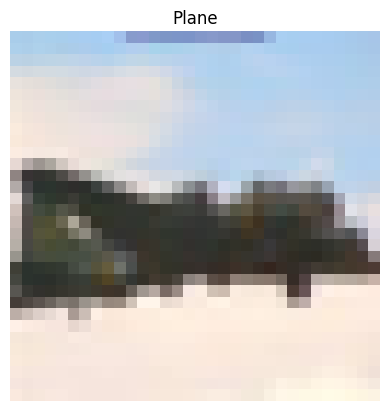

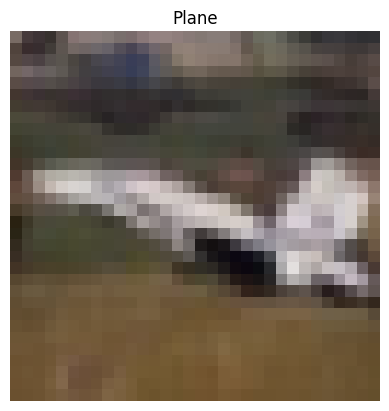

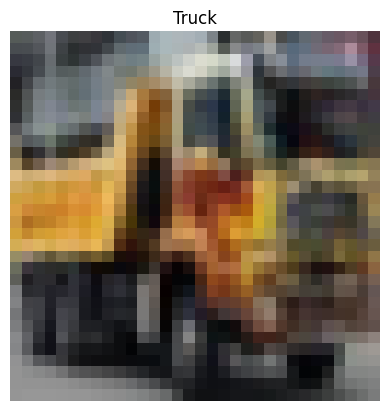

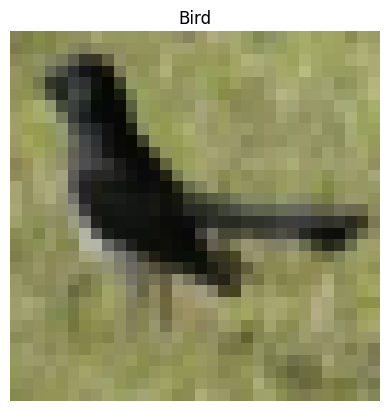

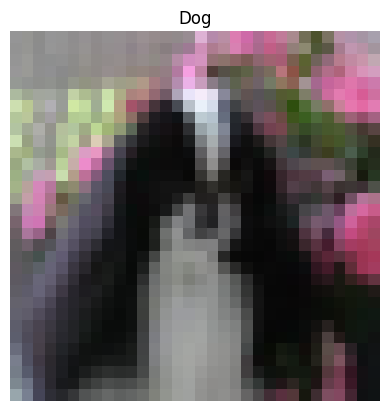

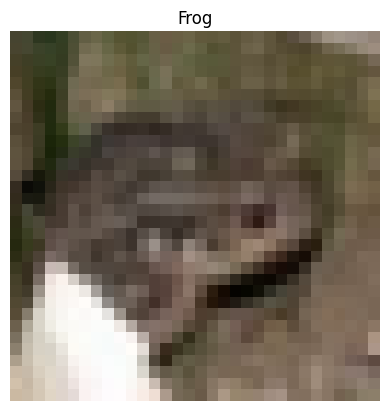

In [3]:
for image, class_index in ConcatDataset([
    Subset(trainset, torch.arange(21, 23)),
    Subset(valset, torch.arange(37, 39)),
    Subset(testset, torch.arange(42, 44)),
]):
    display_dataset_image(image, classes[class_index])

## Projektujemy architekturę sieci neuronowej

Bazową strukturę postanowiłem wzbogacić o przejścia rezydualne. Każda warstwa
konwolucyjna to w zasadzie cztery powielone warstwy, które posiadają dwa
przejścia. Poniżej zamieszczam implementację mojej architektury w PyTorch.

In [4]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        subblock_index: int,
        in_channels: int,
        out_channels: int,
        kernel_size=3
    ):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        self.projection: nn.Module | None = None
        if in_channels != out_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size),
                nn.BatchNorm2d(out_channels)
            )

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=0 if subblock_index == 0 else kernel_size // 2,
                bias=False
            ),
            nn.BatchNorm2d(out_channels)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                bias=False
            ),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x if self.projection is None else self.projection(x)

        out = self.layer1(x)
        out = self.relu(out)

        out = self.layer2(out)
        out += residual
        out = self.relu(out)

        return out


class ForceNet(nn.Module):
    def __init__(self, layers: Sequence[int], class_count=1_000):
        super().__init__()

        self.in_channels = 3

        # ResNet layers.
        self.layer1 = self.__make_layer(6, layers[0])
        self.layer2 = self.__make_layer(16, layers[1])

        self.final_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=400, out_features=120),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=class_count),
        )

    def __make_layer(
        self,
        out_channels: int,
        block_count: int,
    ) -> nn.Sequential:
        blocks: list[nn.Module] = [
            ResidualBlock(
                subblock_index=0,
                in_channels=self.in_channels,
                out_channels=out_channels,
                kernel_size=5
            )
        ]
        self.in_channels = out_channels
        for i in range(1, block_count):
            blocks.append(ResidualBlock(
                subblock_index=i,
                in_channels=self.in_channels,
                out_channels=out_channels,
                kernel_size=5
            ))

        return nn.Sequential(*blocks, nn.AvgPool2d(kernel_size=2, stride=2))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.final_layer(x)

        return x


model = ForceNet(layers=(2, 2), class_count=len(classes))

In [5]:
print(model)

print()

count: int = 0
for name, param in model.named_parameters():
    count += 1
    print(name)
print(f"Total: {count}.")

ForceNet(
  (layer1): Sequential(
    (0): ResidualBlock(
      (relu): ReLU(inplace=True)
      (projection): Sequential(
        (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer1): Sequential(
        (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Sequential(
        (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (layer2): Se

W PyTorchu nie potrzeba inicjalizować wag sieci neuronowej. PyTorch
automatycznie i niejawnie korzysta z inicjalizacji dystrybucji Kaiminga He dla
warstw konwolucyjnych i liniowych. Można także manualnie zainicjalizować warstwy
za pomocą modułu `torch.nn.init`.

## Zapętlamy się w treningu

Do treningu, walidacji wykorzystałem funkcję kosztu Categorical Cross-Entropy
Loss i optymalizatora Adam.

In [6]:
# Create the ForceNet (LeNet-5 and ResNet combination).
model = ForceNet(layers=(2, 2), class_count=len(classes))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [7]:
def train_and_validate(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device | None = None,
    epoch_count: int = 10
) -> None:
    def log(epoch: int, message: str) -> None:
        pretty_date: str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{pretty_date} — Epoch [{epoch + 1}/{epoch_count}] — {message}")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    log_interval: float = 10.  # In seconds.

    for epoch in range(epoch_count):
        log(epoch, "Starting training.")

        cumulative_train_loss: float = 0.
        model.train()
        base_time: float = time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            current_time: float = time()
            if current_time - base_time >= log_interval:
                base_time = current_time
                average_train_loss: float \
                    = cumulative_train_loss / len(trainloader)
                log(epoch, f"Train Loss: {average_train_loss:.4f}.")

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cumulative_train_loss += loss.item()

        log(epoch, "Training finished.")

        average_train_loss: float = cumulative_train_loss / len(trainloader)

        log(epoch, "Starting validation.")

        cumulative_val_loss: float = 0.
        correct: int = 0
        total: int = 0
        model.eval()
        base_time = time()
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)

                current_time: float = time()
                if current_time - base_time >= log_interval:
                    base_time = current_time
                    average_val_loss: float \
                        = cumulative_val_loss / len(valloader)
                    log(epoch, f"Validation Loss: {average_val_loss:.4f}.")

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                cumulative_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, dim=1)

                total += labels.size(dim=0)
                correct += (predicted == labels).sum().item()

        average_val_loss = cumulative_val_loss / len(valloader)
        val_accuracy = correct / total

        log(epoch, "Validation finished.")

        log(
            epoch,
            f"Train Loss: {average_train_loss:.4f}, "
                f"Validation Loss: {average_val_loss:.4f}, "
                f"Validation Accuracy: {val_accuracy:.2%}."
        )

In [8]:
def test(
    model: nn.Module,
    testloader: DataLoader,
    criterion: nn.Module,
    device: torch.device | None = None,
) -> float:
    model.eval()
    cumulative_loss: float = 0.
    correct: int = 0
    total: int = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            cumulative_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)

            total += labels.size(dim=0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total

    print(
        f"Test Loss: {cumulative_loss / len(testloader):.4f} "
        f"Test Accuracy: {test_accuracy:.2%}."
    )

    return test_accuracy

### Uzyskane wyniki

#### Trening

```plain
2024-11-02 22:19:57 — Epoch [1/10] — Train Loss: 0.0475.
2024-11-02 22:20:07 — Epoch [1/10] — Train Loss: 0.2511.
2024-11-02 22:20:17 — Epoch [1/10] — Train Loss: 0.4468.
2024-11-02 22:20:27 — Epoch [1/10] — Train Loss: 0.6606.
2024-11-02 22:20:37 — Epoch [1/10] — Train Loss: 0.8707.
2024-11-02 22:20:47 — Epoch [1/10] — Train Loss: 1.0746.
2024-11-02 22:20:57 — Epoch [1/10] — Train Loss: 1.2473.
2024-11-02 22:21:07 — Epoch [1/10] — Train Loss: 1.4131.
2024-11-02 22:21:30 — Epoch [1/10] — Training finished.
2024-11-02 22:21:30 — Epoch [1/10] — Starting validation.
2024-11-02 22:21:59 — Epoch [1/10] — Validation finished.
2024-11-02 22:21:59 — Epoch [1/10] — Train Loss: 1.4604, Validation Loss: 1.2996, Validation Accuracy: 52.60%.
2024-11-02 22:21:59 — Epoch [2/10] — Starting training.
2024-11-02 22:22:09 — Epoch [2/10] — Train Loss: 0.0429.
2024-11-02 22:22:19 — Epoch [2/10] — Train Loss: 0.2066.
2024-11-02 22:22:29 — Epoch [2/10] — Train Loss: 0.3646.
2024-11-02 22:22:39 — Epoch [2/10] — Train Loss: 0.5179.
2024-11-02 22:22:49 — Epoch [2/10] — Train Loss: 0.6716.
2024-11-02 22:22:59 — Epoch [2/10] — Train Loss: 0.8267.
2024-11-02 22:23:09 — Epoch [2/10] — Train Loss: 0.9651.
2024-11-02 22:23:19 — Epoch [2/10] — Train Loss: 1.1115.
2024-11-02 22:23:41 — Epoch [2/10] — Training finished.
2024-11-02 22:23:41 — Epoch [2/10] — Starting validation.
2024-11-02 22:24:10 — Epoch [2/10] — Validation finished.
2024-11-02 22:24:10 — Epoch [2/10] — Train Loss: 1.1313, Validation Loss: 1.0968, Validation Accuracy: 60.76%.
2024-11-02 22:24:10 — Epoch [3/10] — Starting training.
2024-11-02 22:24:20 — Epoch [3/10] — Train Loss: 0.0380.
2024-11-02 22:24:30 — Epoch [3/10] — Train Loss: 0.1781.
2024-11-02 22:24:40 — Epoch [3/10] — Train Loss: 0.3139.
2024-11-02 22:24:50 — Epoch [3/10] — Train Loss: 0.4454.
2024-11-02 22:25:00 — Epoch [3/10] — Train Loss: 0.5732.
2024-11-02 22:25:10 — Epoch [3/10] — Train Loss: 0.7009.
2024-11-02 22:25:20 — Epoch [3/10] — Train Loss: 0.8297.
2024-11-02 22:25:30 — Epoch [3/10] — Train Loss: 0.9539.
2024-11-02 22:25:53 — Epoch [3/10] — Training finished.
2024-11-02 22:25:53 — Epoch [3/10] — Starting validation.
2024-11-02 22:26:22 — Epoch [3/10] — Validation finished.
2024-11-02 22:26:22 — Epoch [3/10] — Train Loss: 0.9889, Validation Loss: 1.0985, Validation Accuracy: 61.12%.
2024-11-02 22:26:22 — Epoch [4/10] — Starting training.
2024-11-02 22:26:32 — Epoch [4/10] — Train Loss: 0.0278.
2024-11-02 22:26:42 — Epoch [4/10] — Train Loss: 0.1526.
2024-11-02 22:26:52 — Epoch [4/10] — Train Loss: 0.2747.
2024-11-02 22:27:02 — Epoch [4/10] — Train Loss: 0.4002.
2024-11-02 22:27:12 — Epoch [4/10] — Train Loss: 0.5184.
2024-11-02 22:27:22 — Epoch [4/10] — Train Loss: 0.6340.
2024-11-02 22:27:32 — Epoch [4/10] — Train Loss: 0.7528.
2024-11-02 22:27:42 — Epoch [4/10] — Train Loss: 0.8732.
2024-11-02 22:28:04 — Epoch [4/10] — Training finished.
2024-11-02 22:28:04 — Epoch [4/10] — Starting validation.
2024-11-02 22:28:33 — Epoch [4/10] — Validation finished.
2024-11-02 22:28:33 — Epoch [4/10] — Train Loss: 0.9053, Validation Loss: 1.2109, Validation Accuracy: 58.90%.
2024-11-02 22:28:33 — Epoch [5/10] — Starting training.
2024-11-02 22:28:43 — Epoch [5/10] — Train Loss: 0.0301.
2024-11-02 22:28:53 — Epoch [5/10] — Train Loss: 0.1437.
2024-11-02 22:29:04 — Epoch [5/10] — Train Loss: 0.2587.
2024-11-02 22:29:14 — Epoch [5/10] — Train Loss: 0.3710.
2024-11-02 22:29:24 — Epoch [5/10] — Train Loss: 0.4794.
2024-11-02 22:29:34 — Epoch [5/10] — Train Loss: 0.5966.
2024-11-02 22:29:44 — Epoch [5/10] — Train Loss: 0.7100.
2024-11-02 22:29:54 — Epoch [5/10] — Train Loss: 0.8200.
2024-11-02 22:30:16 — Epoch [5/10] — Training finished.
2024-11-02 22:30:16 — Epoch [5/10] — Starting validation.
2024-11-02 22:30:45 — Epoch [5/10] — Validation finished.
2024-11-02 22:30:45 — Epoch [5/10] — Train Loss: 0.8381, Validation Loss: 0.9251, Validation Accuracy: 67.14%.
2024-11-02 22:30:45 — Epoch [6/10] — Starting training.
2024-11-02 22:30:55 — Epoch [6/10] — Train Loss: 0.0233.
2024-11-02 22:31:05 — Epoch [6/10] — Train Loss: 0.1218.
2024-11-02 22:31:15 — Epoch [6/10] — Train Loss: 0.2169.
2024-11-02 22:31:25 — Epoch [6/10] — Train Loss: 0.3146.
2024-11-02 22:31:35 — Epoch [6/10] — Train Loss: 0.4085.
2024-11-02 22:31:45 — Epoch [6/10] — Train Loss: 0.5135.
2024-11-02 22:31:55 — Epoch [6/10] — Train Loss: 0.6133.
2024-11-02 22:32:05 — Epoch [6/10] — Train Loss: 0.7102.
2024-11-02 22:32:33 — Epoch [6/10] — Training finished.
2024-11-02 22:32:33 — Epoch [6/10] — Starting validation.
2024-11-02 22:33:03 — Epoch [6/10] — Validation finished.
2024-11-02 22:33:03 — Epoch [6/10] — Train Loss: 0.7880, Validation Loss: 0.9210, Validation Accuracy: 68.24%.
2024-11-02 22:33:03 — Epoch [7/10] — Starting training.
2024-11-02 22:33:13 — Epoch [7/10] — Train Loss: 0.0192.
2024-11-02 22:33:23 — Epoch [7/10] — Train Loss: 0.1122.
2024-11-02 22:33:33 — Epoch [7/10] — Train Loss: 0.2062.
2024-11-02 22:33:43 — Epoch [7/10] — Train Loss: 0.2968.
2024-11-02 22:33:53 — Epoch [7/10] — Train Loss: 0.3912.
2024-11-02 22:34:03 — Epoch [7/10] — Train Loss: 0.4866.
2024-11-02 22:34:13 — Epoch [7/10] — Train Loss: 0.5816.
2024-11-02 22:34:23 — Epoch [7/10] — Train Loss: 0.6763.
2024-11-02 22:34:49 — Epoch [7/10] — Training finished.
2024-11-02 22:34:49 — Epoch [7/10] — Starting validation.
2024-11-02 22:35:19 — Epoch [7/10] — Validation finished.
2024-11-02 22:35:19 — Epoch [7/10] — Train Loss: 0.7368, Validation Loss: 0.9525, Validation Accuracy: 67.60%.
2024-11-02 22:35:19 — Epoch [8/10] — Starting training.
2024-11-02 22:35:29 — Epoch [8/10] — Train Loss: 0.0217.
2024-11-02 22:35:39 — Epoch [8/10] — Train Loss: 0.1039.
2024-11-02 22:35:49 — Epoch [8/10] — Train Loss: 0.1946.
2024-11-02 22:35:59 — Epoch [8/10] — Train Loss: 0.2828.
2024-11-02 22:36:09 — Epoch [8/10] — Train Loss: 0.3619.
2024-11-02 22:36:19 — Epoch [8/10] — Train Loss: 0.4382.
2024-11-02 22:36:29 — Epoch [8/10] — Train Loss: 0.5315.
2024-11-02 22:36:39 — Epoch [8/10] — Train Loss: 0.6176.
2024-11-02 22:37:08 — Epoch [8/10] — Training finished.
2024-11-02 22:37:08 — Epoch [8/10] — Starting validation.
2024-11-02 22:37:38 — Epoch [8/10] — Validation finished.
2024-11-02 22:37:38 — Epoch [8/10] — Train Loss: 0.6961, Validation Loss: 0.8447, Validation Accuracy: 70.76%.
2024-11-02 22:37:38 — Epoch [9/10] — Starting training.
2024-11-02 22:37:48 — Epoch [9/10] — Train Loss: 0.0207.
2024-11-02 22:37:58 — Epoch [9/10] — Train Loss: 0.1046.
2024-11-02 22:38:08 — Epoch [9/10] — Train Loss: 0.1909.
2024-11-02 22:38:18 — Epoch [9/10] — Train Loss: 0.2736.
2024-11-02 22:38:28 — Epoch [9/10] — Train Loss: 0.3579.
2024-11-02 22:38:38 — Epoch [9/10] — Train Loss: 0.4395.
2024-11-02 22:38:48 — Epoch [9/10] — Train Loss: 0.5236.
2024-11-02 22:38:58 — Epoch [9/10] — Train Loss: 0.6089.
2024-11-02 22:39:24 — Epoch [9/10] — Training finished.
2024-11-02 22:39:24 — Epoch [9/10] — Starting validation.
2024-11-02 22:39:53 — Epoch [9/10] — Validation finished.
2024-11-02 22:39:53 — Epoch [9/10] — Train Loss: 0.6571, Validation Loss: 0.8988, Validation Accuracy: 68.94%.
2024-11-02 22:39:53 — Epoch [10/10] — Starting training.
2024-11-02 22:40:03 — Epoch [10/10] — Train Loss: 0.0165.
2024-11-02 22:40:13 — Epoch [10/10] — Train Loss: 0.0907.
2024-11-02 22:40:23 — Epoch [10/10] — Train Loss: 0.1668.
2024-11-02 22:40:33 — Epoch [10/10] — Train Loss: 0.2410.
2024-11-02 22:40:44 — Epoch [10/10] — Train Loss: 0.3212.
2024-11-02 22:40:54 — Epoch [10/10] — Train Loss: 0.4014.
2024-11-02 22:41:04 — Epoch [10/10] — Train Loss: 0.4791.
2024-11-02 22:41:14 — Epoch [10/10] — Train Loss: 0.5594.
2024-11-02 22:41:41 — Epoch [10/10] — Training finished.
2024-11-02 22:41:41 — Epoch [10/10] — Starting validation.
2024-11-02 22:42:11 — Epoch [10/10] — Validation finished.
2024-11-02 22:42:11 — Epoch [10/10] — Train Loss: 0.6226, Validation Loss: 0.8379, Validation Accuracy: 71.74%.
```

#### Sprawdzenie poprawności

Koszt wyniósł $0.8413$, a dokładność $71.79\%$.

## Hiperparametryzujemy sieć i jej trening

Do poszukiwania jak najlepszych hiperparametrów wybrałem framework Optuna.
Przeszukiwanie przestrzeni działa na szukaniu odpowiednich parametrów,
korzystając z odpowiednich algorytmów do szybkiego i efektywnego wybierania
odpowiednich wartości.
Niestety z powodu braku do przeszukiwania przestrzeni hiperparametrów wybrałem
tylko stałą uczącą i rozmiar partii. Dodatkowo liczba epok i iteracji jest
bardzo niska, odpowiednio 2 i 4 :(

In [9]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 128)

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset, valset = data.random_split(
        torchvision.datasets.CIFAR10(
            root="./data", train=True, download=True, transform=transform
        ),
        lengths=(.9, .1),
        generator=torch.Generator().manual_seed(2137)
    )
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=worker_count
    )
    valloader = DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=worker_count
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=worker_count
    )

    classes = ("plane", "car", "bird", "cat",
            "deer", "dog", "frog", "horse", "ship", "truck")

    # Create the ForceNet (LeNet-5 and ResNet combination).
    model = ForceNet(layers=(2, 2), class_count=len(classes))

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_and_validate(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        device,
        epoch_count=2
    )

    accuracy: float = test(model, testloader, criterion, device)

    return accuracy

### Najlepsze uzyskane parametry

- Dokładność: $52.56\%$.
- Stała ucząca: $0.00999$.
- Rozmiar partii: $67$.

Powyższe wyniki wykorzystałem nieświadomie w pierwszej fazie treningu, więc
wyszło bardzo przyzwoicie. Przeszukiwanie przestrzeni hiperparametrów to bardzo
dobra metoda do zoptymalizowania jak najbardziej swojej architektury -
wyciskania soku ;)